In [84]:
import wikipedia
import pandas as pd
import numpy as np
import os
import sys
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [2]:
sys.path.insert(0, '../src/data')
from etl import *

def xml_to_soup(fp):
    '''
    Processes xml data using beautiful soup and
    returns list of data for each page
    '''
    content = []
    with open(fp, encoding = 'utf8') as file:

        content = file.readlines()
        content = "".join(content)
        soup = BeautifulSoup(content, "xml")
        
    pages = soup.findAll("page")
    return pages

def soup_to_df(pages):
    '''
    Converts soupified xml data for Wiki pages 
    into dataframe
    
    pages: list of xml data for each page
    '''
    data = {}
    for page in pages:
        title = page.title.text
        revisions = page.findAll("revision")

        for revision in revisions:
            r_id = revision.id.text 
            time = revision.timestamp.text
            try:
                try:
                    username = revision.contributor.username.text
                except: 
                    username = revision.contributor.ip.text
            except:
                username = 'N/A'
            text = revision.format.next_sibling.next_sibling.text
            if title in data:
                data[title].append([title, r_id, time, username, text])
            else:
                data[title] = [[title, r_id, time, username, text]]
    
    dframes = []
    for page in data:

        df = pd.DataFrame(data[page], columns = ['title', 'id', 'time', 'username', 'text'])

        hist = [] #history of text
        version = [] #edit version
        username = []
        revert = [] #0 or 1
        curr = 1 #to keep track of version

        for idx, row in df.iterrows():
            if row.text not in hist: # not a revert
                hist.append(row.text)
                version.append(curr)
                username.append(row.username)
                revert.append('0')
                curr += 1
            else: #is revert
                temp = hist.index(row.text)
                version.append(version[temp])
                username.append(row.username)

                #if self revert
                if row.username == username[version[temp]]:
                    revert.append('0')
                else:
                    revert.append('1')


        df['version'] = version
        df['revert'] = revert
        dframes.append(df)

    return dframes

def df_to_ld(dframes, outpath):
    '''
    Given a list of cleaned dataframes from xml data,
    produces light dump file into data/raw
    '''
    
    light_dump = ''
    for df in dframes:
        title = df.title[0]
        light_dump = light_dump + title + '\n'
        for idx, row in df.iterrows():
            line = '^^^_' + row.time + ' ' + row.revert + ' ' + str(row.version) + ' ' + row.username
            light_dump = light_dump + line + '\n'
    with open(outpath, 'w') as f:
        f.write(light_dump)
    repo = 'XML Converted to light dump at ' + outpath
    print(repo)
    
    return

def xml_to_light_dump(fp, outfp):
    '''
    Given an input file path and output path, 
    turns the xml file into a light dump 
    and stores it at the output file path
    '''
    #create light dump directory first
    if not os.path.isdir("../data/raw/light_dump"):
        os.mkdir("../data/raw/light_dump")
    
    #convert to light dump
    soup = xml_to_soup(fp)
    dframes = soup_to_df(soup)
    return df_to_ld(dframes, outfp)

In [3]:
fp = "../data/raw/BTS-albums.xml"
outfp = "../data/raw/light_dump/bts_albums.txt"

xml_to_light_dump(fp, outfp)


XML Converted to light dump at ../data/raw/light_dump/bts_albums.txt


### Album release dates

1. Dark & Wild: August 19, 2014
2. Wings: October 10, 2016
3. Love Yourself: Tears: May 18, 2018
4. Map of the Soul: 7: February 21, 2020
5. Be: November 20, 2020

In [4]:
#get range
def date_range(release_date):
    '''
    Given a string with the album release date,
    calculates the given time range to extract data from
    '''
    date = pd.to_datetime(release_date)
    start = date - timedelta(days=2)
    end = date + timedelta(days = 14)
    return start, end
    

In [7]:
start, end = date_range("August 19, 2014")

In [182]:
def lightdump_read_n(fp, n = 100):
    '''
	Reads in n lightdump pages and returns a list of all titles 
    read and their corresponding data as a DataFrame
	:param fp: input filepath
	:param n: number of articles to read
	:return: list of article titles, list of corresponding article lightdump data as DataFrame
	'''
    titles = []
    dataframes = []

    with open(fp) as file:
        df = pd.DataFrame(columns = ['timestamp', 'revert', 'revision_id', 'user'])
        page = 0
        for line in file:
            if '^^^_' not in line:
                title = line.strip('\n').strip()
                titles.append(title)

                if title != titles[page]:
                    page += 1
                    
                    df['timestamp'] = pd.to_datetime(df['timestamp'])
                    
                    dataframes.append(df)
                    
                    df = pd.DataFrame(columns = ['timestamp', 'revert', 'revision_id', 'user'])

                    if page == n:
                        break
            else:
                data = line.strip("^^^_").strip('\n').split()
                row = pd.Series(dtype = 'object')

                row['timestamp'] = data[0]
                row['revert'] = int(data[1])
                row['revision_id'] = int(data[2])
                row['user'] = data[3]

                df = df.append(row, ignore_index = True)
    dataframes.append(df)

    return [titles, dataframes]

In [9]:
#Check bts album time series data
fp = "../data/raw/light_dump/bts_albums.txt"
titles, dfs = lightdump_read_n(fp, 5)


### Album: Dark & Wild

In [10]:
titles[0]

'Dark & Wild'

In [12]:
dfs[0].head()

,timestamp,revert,revision_id,user
0,2014-11-12 17:21:59+00:00,0,1,Htruc
1,2014-11-12 17:33:23+00:00,0,2,Starcheerspeaksnewslostwars
2,2014-11-12 17:33:55+00:00,0,3,Starcheerspeaksnewslostwars
3,2014-11-12 18:43:50+00:00,0,4,Karlhard
4,2014-11-12 18:46:06+00:00,0,5,Karlhard


### Album: Be

In [133]:
titles[4]

'Be (BTS album)'

In [13]:
dfs[4].head()

,timestamp,revert,revision_id,user
0,2020-09-27T15:37:41Z,0,1,Lirim.Z
1,2020-09-27T15:40:52Z,0,2,Lirim.Z
2,2020-09-27T15:41:31Z,0,3,Lirim.Z
3,2020-09-27T15:41:46Z,0,4,Lirim.Z
4,2020-09-27T15:43:51Z,0,5,Lirim.Z


In [14]:
start, end = date_range("November 20, 2020")
start

Timestamp('2020-11-18 00:00:00')

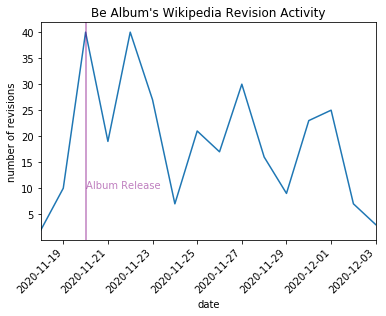

In [168]:
be = dfs[4]
be.timestamp = pd.DatetimeIndex(pd.to_datetime(be.timestamp)).tz_localize(None)
filtered = be[(be.timestamp > start) & (be.timestamp < end)]

filtered = filtered.sort_values(by = 'timestamp', ascending = True)
filtered.timestamp = filtered.timestamp.apply(lambda x: x.date())
data = filtered.groupby(by = 'timestamp').count()

fig, ax = plt.subplots()
data.user.plot()
plt.ylabel('number of revisions')
plt.xlabel('date')
plt.xticks(rotation=45, ha="right")
plt.title('Be Album\'s Wikipedia Revision Activity')

x = release_date
y = data[data.index == release_date].user[0]

ax.annotate('Album Release', xy = (x ,10), color='purple', alpha = 0.5)

ax.axvline(x, color='purple', alpha=0.5)

plt.show()

### for all albums

In [185]:
fp = "../data/raw/light_dump/bts_albums.txt"
titles, dfs = lightdump_read_n(fp, 5)

In [195]:
release_dates = {
    'Dark & Wild': 'August 19, 2014',
    'Wings (BTS album)': 'October 10, 2016',
    'Love Yourself: Tear': 'May 18, 2018',
    'Map of the Soul: 7': 'February 21, 2020',
    'Be (BTS album)': 'November 20, 2020'
}

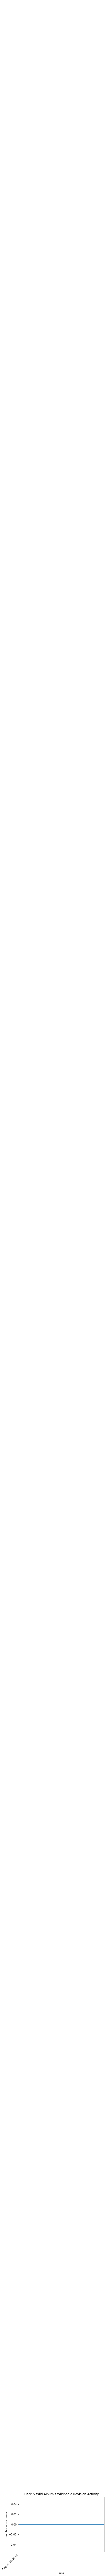

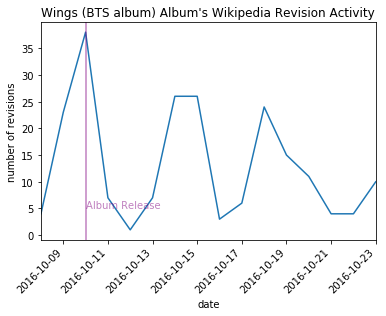

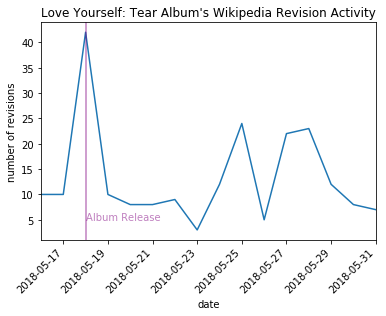

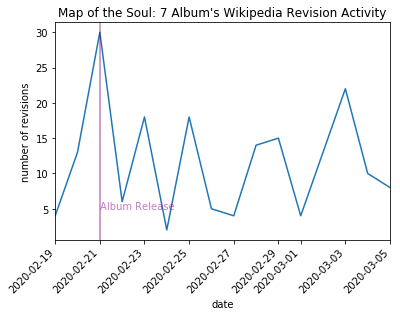

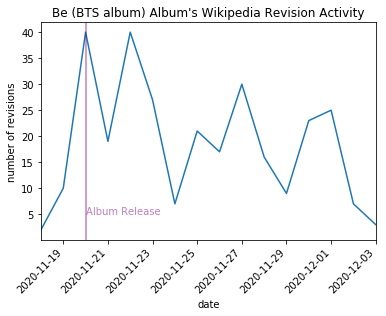

In [211]:
d = list(zip(titles, dfs))
for [title, df] in d:
    release_date = release_dates[title]
    start, end = date_range(release_date)
    
    df.timestamp = pd.DatetimeIndex(pd.to_datetime(df.timestamp)).tz_localize(None)
    filtered = df[(df.timestamp > start) & (df.timestamp < end)]
    filtered = filtered.sort_values(by = 'timestamp', ascending = True)
    filtered.timestamp = filtered.timestamp.apply(lambda x: x.date())
    data = filtered.groupby(by = 'timestamp').count()

    if data.shape[0] == 0:
        data = pd.DataFrame()
        data['timestamp'] = pd.date_range(start= start, end = end)
        data['user'] = [0 for i in range(len(data.timestamp))]
        
    fig, ax = plt.subplots()
    data.user.plot()
    plt.ylabel('number of revisions')
    plt.xlabel('date')
    plt.xticks(rotation=45, ha="right")
    plt.title(title + ' Album\'s Wikipedia Revision Activity')

    x = release_date
    ax.annotate('Album Release', xy = (x ,5), color='purple', alpha = 0.5)

    ax.axvline(x, color='purple', alpha=0.5)

    plt.show()

In [147]:
release_date = "November 20, 2020"
release_date = pd.to_datetime(release_date).date()

In [169]:
#check bts main page time series data
fp = "../data/raw/light_dump/Kpop_ld.txt"
titles, dfs = lightdump_read_n(fp, 0)

In [170]:
titles[0]

'BTS'

In [172]:
bts = dfs[0]

In [173]:
bts.head()

,timestamp,revert,revision_id,user
0,2013-07-04 19:45:15+00:00,0,1,Hinorisakamachi
1,2013-07-04 19:47:39+00:00,0,2,Hinorisakamachi
2,2013-07-04 19:59:17+00:00,0,3,Hinorisakamachi
3,2013-07-04 19:59:53+00:00,0,4,Hinorisakamachi
4,2013-07-04 20:19:54+00:00,0,5,39.198.179.240


In [174]:

bts.timestamp = pd.DatetimeIndex(pd.to_datetime(bts.timestamp,unit='ms')).tz_localize(None)

In [176]:
bts

,timestamp,revert,revision_id,user
0,2013-07-04 19:45:15,0,1,Hinorisakamachi
1,2013-07-04 19:47:39,0,2,Hinorisakamachi
2,2013-07-04 19:59:17,0,3,Hinorisakamachi
3,2013-07-04 19:59:53,0,4,Hinorisakamachi
4,2013-07-04 20:19:54,0,5,39.198.179.240
...,...,...,...,...
995,2014-12-21 12:02:18,0,780,121.6.37.231
996,2014-12-21 17:32:02,0,781,49.144.223.122
997,2014-12-22 07:36:52,0,782,Exo-l
998,2014-12-23 05:38:08,0,783,99.64.240.60


In [175]:
bts[(bts.timestamp > start) & (bts.timestamp < end)]

,timestamp,revert,revision_id,user


In [96]:
bts.timestamp[0].tz_localize(None)

Timestamp('2013-07-04 19:45:15')

In [97]:
start

Timestamp('2014-08-17 00:00:00')